**Table of contents**<a id='toc0_'></a>    
- 1. [Alaska overview  ](#toc1_)    
- 2. [Load data ](#toc2_)    
  - 2.1. [Download earthquake catalog (USGS)](#toc2_1_)    
  - 2.2. [Load tremor data (Wech) ](#toc2_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Alaska overview   [&#128285;](#toc0_)

In [3]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import requests
import io

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

# 2. <a id='toc2_'></a>Load data  [&#128285;](#toc0_)

## 2.1. <a id='toc2_1_'></a>Download earthquake catalog (USGS) [&#128285;](#toc0_)

In [17]:
# Download usgs catalog
# Format
format_usgs = "format=csv"
format_isc = "format=text"  # something that looks like csv

# Date range
t0 = "2013-01-01"
t1 = "2016-01-01"
date_range = f"starttime={t0}&endtime={t1}" 

# Geographic range
minlat = 59
maxlat = 65
minlon = -154
maxlon = -143
geographic_range = f"minlatitude={minlat}&maxlatitude={maxlat}&minlongitude={minlon}&maxlongitude={maxlon}"

# Magnitude range
minmag = 1.6
mag_range = f"minmagnitude={minmag}"

# Event-type
event_type = "eventtype=earthquake"

url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?{format_usgs}&{date_range}&{geographic_range}&{mag_range}&{event_type}"  # pb with this one is the limit of 20k events
# url = f"https://www.isc.ac.uk/fdsnws/event/1/query?{format_isc}&{date_range}&{geographic_range}"
print(url)
stream = requests.get(url).content

names = ["time", "lat", "lon", "depth", "mag", "magType", "nst", "gap", "dmin", "rms", "net", "id", "updated", "place", "type", "horizontalError", "depthError", "magError", "magNst", "status", "locationSource", "magSource"]
eq = pd.read_csv(io.StringIO(stream.decode('utf-8')), names=names, skiprows=1)
eq['date'] = pd.to_datetime(eq['time'])

https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=2013-01-01&endtime=2016-01-01&minlatitude=59&maxlatitude=65&minlongitude=-154&maxlongitude=-143&minmagnitude=1.6&eventtype=earthquake


## 2.2. <a id='toc2_2_'></a>Load tremor data (Wech)  [&#128285;](#toc0_)

In [27]:
# Load data
path = workdir + 'projects/data/Catalogs/alaska_wech16_0815/AK_tremor.txt'
trm = pd.read_csv(path, delimiter='\t', skiprows=1, names=['date', 'lon', 'lat'])

trm['date'] = pd.to_datetime(trm['date'])

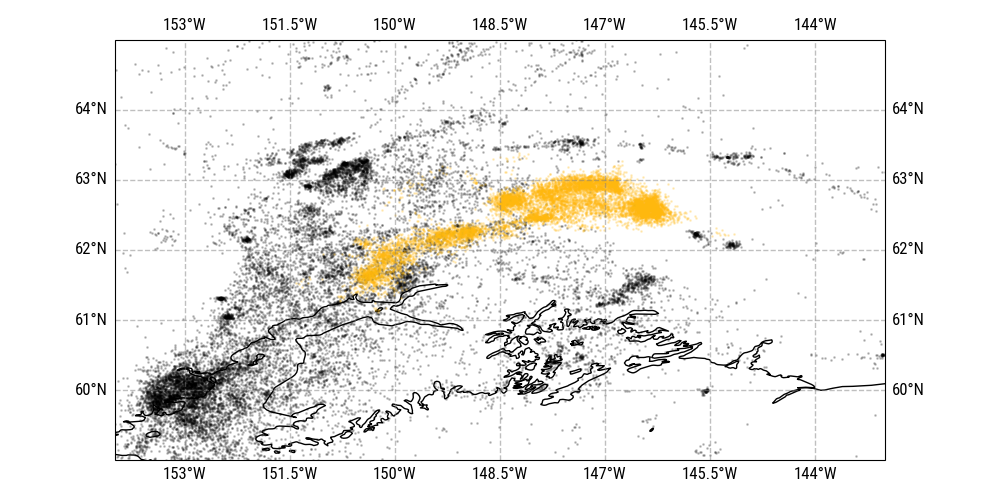

In [28]:
# A map of it
fig = plt.figure(figsize=(10, 5))

dlon = (trm.lon.max() - trm.lon.min())
dlat = (trm.lat.max() - trm.lat.min())
extent = [minlon, maxlon, minlat, maxlat]

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

ax.plot(eq.lon, eq.lat, 'o', c=to_rgba('k', .2), ms=1, transform=ccrs.PlateCarree())
ax.plot(trm.lon, trm.lat, 'o', c=to_rgba('C2', .2), ms=1, transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

ax.set_extent(extent)

plt.tight_layout()
plt.show()

In [29]:
# Define transect and project tremor onto it
transect_line = {
    'W': {'lon': -150.9, 'lat': 61.47},
    'E': {'lon': -145.9, 'lat': 63.06},
}

t = transect(trm.lon.values, trm.lat.values, transect_line['W']['lon'], transect_line['W']['lat'], transect_line['E']['lon'], transect_line['E']['lat'])
trm['xf'] = t[0]
trm['yf'] = t[1]

t = transect(eq.lon.values, eq.lat.values, transect_line['W']['lon'], transect_line['W']['lat'], transect_line['E']['lon'], transect_line['E']['lat'])
eq['xf'] = t[0]
eq['yf'] = t[1]
eq_near = eq[(abs(eq['yf']) > 50) & (eq['xf'] < 320) & (eq['xf'] > -30)]


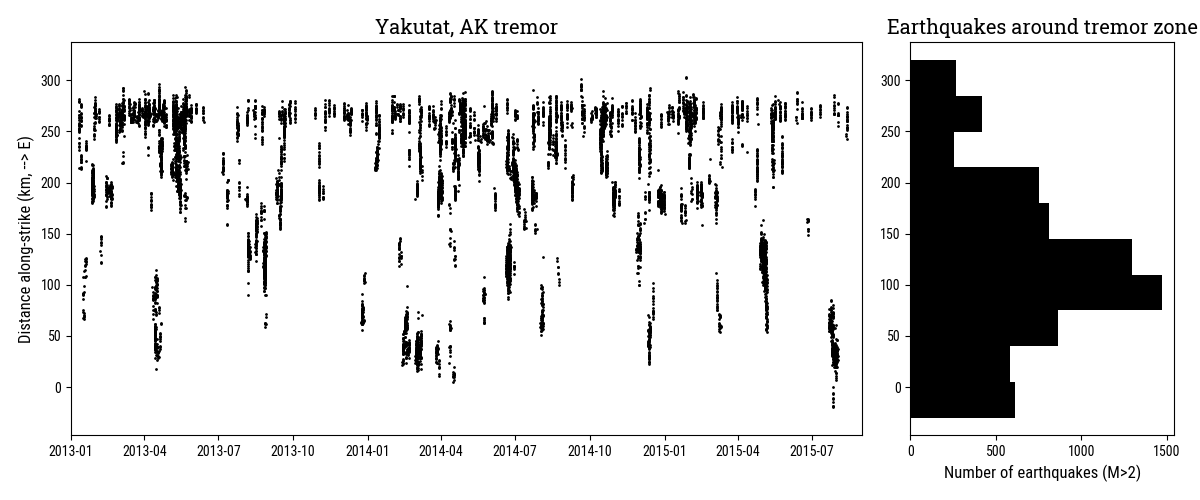

In [30]:
# Show the activity in space and time
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])

ax = fig.add_subplot(gs[0])
ax.set_title('Yakutat, AK tremor', fontname='Roboto Slab')
ax.set_ylabel('Distance along-strike (km, --> E)')

ax.plot(trm.date, trm.xf, 'o', color='k', markersize=1)

ax.set_xlim(np.datetime64('2013-01-01'), np.datetime64('2015-09-01'))

ax = fig.add_subplot(gs[1], sharey=ax)
ax.set_title('Earthquakes around tremor zone', fontname='Roboto Slab')
ax.set_xlabel('Number of earthquakes (M>2)')

ax.hist(eq_near.xf, bins=10, orientation='horizontal', color='k')

plt.tight_layout()